In [1]:
# Simple training of multi-fidelity MEGNet bandgap model for materials project (version:mp.2019.4.1.json)
import gzip
import json
from typing import List

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from copy import deepcopy

import math

# Import megnet related modules
from pymatgen.core import Structure
from matgl.ext.pymatgen import get_element_list, Structure2Graph
from matgl.layers._bond import BondExpansion
from torch.optim.lr_scheduler import CosineAnnealingLR
from matgl.graph.data import MEGNetDataset, _collate_fn, MGLDataLoader
from matgl.models import MEGNet
#from matgl.utils.training import ModelTrainer
from sklearn.model_selection import train_test_split


# os.chdir('/blue/hennig/ericfonseca/M2QM/TMQM/workspace/notebooks')
os.chdir(r'C:\Users\efons\Documents\GitHub\m2qm_ml')
# disable warnings in python outputs
import warnings
warnings.filterwarnings('ignore')

In [2]:
cif_path = './sco/cif'
from pymatgen.core import Structure
from pymatgen.io.ase import AseAtomsAdaptor
from ase.io import read
def get_struc(cif_path):
    try:
        struc_ase = read(cif_path)
        struc = AseAtomsAdaptor.get_structure(struc_ase)
    except:
        print(cif_path)
        struc = None
    return struc
cif_paths = [os.path.abspath(os.path.join(cif_path,i)) for i in os.listdir(cif_path) if i.endswith('.cif')][0:250]
import dask
strucs = dask.compute([dask.delayed(get_struc)(i) for i in cif_paths])[0]
len(strucs)


250

In [3]:
elem_list = get_element_list(strucs)
elem_list



('H',
 'B',
 'C',
 'N',
 'O',
 'F',
 'Na',
 'Mg',
 'Al',
 'Si',
 'P',
 'S',
 'Cl',
 'K',
 'Cr',
 'Mn',
 'Fe',
 'Co',
 'Zn',
 'Ge',
 'As',
 'Se',
 'Br',
 'Mo',
 'Sb',
 'I',
 'Dy')

In [4]:
cry_graph = Structure2Graph(element_types=elem_list, cutoff=5.0)
cry_graph

In [5]:
import pandas as pd
import numpy as np
df = pd.read_csv('./sco/data.csv')
targets = df['SpinCrossoverEnergy'].values
cif_df = pd.DataFrame()
import re
cif_df['ID'] = [re.split(r'\\|/',i)[-1].split('.')[0] for i in cif_paths]
cif_df

,ID
0,ABILUT
1,ACEYOW
2,ACEYOW01
3,ACUFAF
4,ADEQOS
...,...
245,DIMPEU11
246,DIVCAO
247,DIXCOD
248,DMAZCO


In [16]:

df = pd.merge(cif_df, df, on='ID')
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# setup the weight initialization using Xavier scheme
def xavier_init(model):
    for name, param in model.named_parameters():
        if name.endswith(".bias"):
            param.data.fill_(0)
        else:
            if param.dim() < 2:
                bound = math.sqrt(6) / math.sqrt(param.shape[0] + param.shape[0])
                param.data.uniform_(-bound, bound)
            else:
                bound = math.sqrt(6) / math.sqrt(param.shape[0] + param.shape[1])
                param.data.uniform_(-bound, bound)

def get_data(df):
    ids = df['ID'].tolist()
    targets = df['SpinCrossoverEnergy'].values
    # convert the boolean in IsSpinCrossover to int
    attrs = df['IsSpinCrossover'].astype(int).values
    return ids, targets, attrs

train_df, valid_df = train_test_split(train_df, test_size=0.5, random_state=42)
train_ids, train_targets, train_attrs = get_data(train_df)
valid_ids, valid_targets, valid_attrs = get_data(valid_df)
test_ids, test_targets, test_attrs = get_data(test_df)
test_ids, test_targets, test_attrs

(['CAXTIH',
  'ALETAN',
  'BOZNIP',
  'BEHYES',
  'BUZPUJ',
  'CONICH02',
  'CPMNCO01',
  'CONICH05',
  'AMAVAN',
  'BUCZOO',
  'CPMNCO04',
  'CYCPCR01',
  'DEXCUE',
  'DIHZEC',
  'BEPTIA',
  'DAPCOM',
  'COTQUY',
  'APENCP',
  'CITCUD',
  'ATEWAZ',
  'DIXCOD',
  'APICCO07',
  'BZCRCO',
  'BEXNIB10',
  'CITBIT',
  'BAFJEA01',
  'BAZZEG',
  'AMECOA01',
  'AYADEJ',
  'CABGOB',
  'CPMNCO05',
  'AYEKAS',
  'CAVFUA',
  'DAGMAA',
  'ATOFEW',
  'BUXHOR',
  'APICCO06',
  'CPCIFE01',
  'CONICH01',
  'CICMOQ',
  'BZCRCO14',
  'BOZLUZ',
  'BUSXIW',
  'COPKEY',
  'DAMXUL',
  'APICCO02',
  'CEHZIZ',
  'BEXXOT',
  'CIMTID',
  'AZEQAZ'],
 array([-1.9306, -1.4628, -0.0688,  2.628 , -0.3237,  0.4901,  2.2705,
        -0.5822, -1.8176,  1.1175,  2.2723, -0.9655,  2.3009, -0.299 ,
        -0.9479, -0.3031, -0.7613, -0.144 ,  1.8746,  0.2079,  0.0815,
        -0.2605,  2.73  , -0.1015,  1.6243,  3.7648,  3.0127,  1.6272,
        -1.4156,  0.3579,  2.2712, -0.5401,  4.1115, -0.9068, -0.7367,
         1.211

In [17]:
df

,ID,SpinCrossoverEnergy,HomoLumoGap,IsSpinCrossover,TransitionMetal
0,ABILUT,-1.2004,3.3529,False,Cr
1,ACEYOW,0.8681,2.8624,False,Fe
2,ACEYOW01,0.8682,2.8645,False,Fe
3,ACUFAF,2.4450,2.4446,False,Cr
4,ADEQOS,0.6977,1.3704,False,Co
...,...,...,...,...,...
245,DIMPEU11,-1.5126,2.7494,False,Mn
246,DIVCAO,-0.6040,1.4267,False,Mn
247,DIXCOD,0.0815,0.7869,True,Co
248,DMAZCO,-0.4330,1.7411,False,Co


In [18]:

# get the indexes that matches the train, valid, test split
train_idx = cif_df[cif_df['ID'].isin(train_ids)].index.tolist()
valid_idx = cif_df[cif_df['ID'].isin(valid_ids)].index.tolist()
test_idx = cif_df[cif_df['ID'].isin(test_ids)].index.tolist()

train_strucs = [strucs[i] for i in train_idx]
valid_strucs = [strucs[i] for i in valid_idx]
test_strucs = [strucs[i] for i in test_idx]
train_strucs[0]

Structure Summary
Lattice
    abc : 13.7304 5.5516 18.4034
 angles : 90.0 101.964 90.0
 volume : 1372.3400190653074
      A : 13.7304 0.0 0.0
      B : 0.0 5.5516 0.0
      C : -3.8149707426168282 0.0 18.00364212577493
    pbc : True True True
PeriodicSite: Co (3.5399, 2.4005, 7.2155) [0.3692, 0.4324, 0.4008]
PeriodicSite: Co (1.6324, 3.1511, 16.2173) [0.3692, 0.5676, 0.9008]
PeriodicSite: Co (10.4051, 5.1763, 7.2155) [0.8692, 0.9324, 0.4008]
PeriodicSite: Co (8.4976, 0.3753, 16.2173) [0.8692, 0.0676, 0.9008]
PeriodicSite: O (3.8119, 3.4420, 5.6098) [0.3642, 0.6200, 0.3116]
PeriodicSite: O (1.9044, 2.1096, 14.6116) [0.3642, 0.3800, 0.8116]
PeriodicSite: O (10.6771, 0.6662, 5.6098) [0.8642, 0.1200, 0.3116]
PeriodicSite: O (8.7696, 4.8854, 14.6116) [0.8642, 0.8800, 0.8116]
PeriodicSite: O (3.2983, 3.4264, 8.8207) [0.3764, 0.6172, 0.4899]
PeriodicSite: O (1.3908, 2.1252, 17.8225) [0.3764, 0.3828, 0.9899]
PeriodicSite: O (10.1635, 0.6506, 8.8207) [0.8764, 0.1172, 0.4899]
PeriodicSite: O (8

In [19]:
# find the largest structure
largest_struc = max(strucs, key=lambda x: len(x))
num_atoms = 100
train_targets = torch.from_numpy(train_targets).float()

In [20]:
training_set = MEGNetDataset(
    train_strucs,
    train_targets,
    "SpinCrossoverEnergy",
    converter=cry_graph,
    initial=0.0,
    final=6.0,
    num_centers=num_atoms,
    width=0.5,
    #graph_labels=train_attrs,
)


100%|██████████| 100/100 [00:05<00:00, 16.67it/s]


In [21]:
#make a to_cuda_function that will send the graphs and attrs to cuda

def to_cuda(dataset):
    for i in range(len(dataset)):
        dataset[i][0].to('cuda')
        dataset[i][1].to('cuda')
    return dataset

# test
training_set = to_cuda(training_set)
training_set.graphs = [i.to('cuda') for i in training_set.graphs]
#training_set.attrs = training_set.attrs.to('cuda')
training_set.labels = training_set.labels.to('cuda')
training_set.state_attr = training_set.state_attr.to('cuda')
training_set[0]

def dataloader_to_cuda(dataloader):
    dataloader.graphs = [i.to('cuda') for i in dataloader.graphs]
    dataloader.labels = dataloader.labels.to('cuda')
    dataloader.state_attr = dataloader.state_attr.to('cuda')
    return dataloader


In [22]:
validation_set = MEGNetDataset(
    valid_strucs,
    valid_targets,
    "SpinCrossoverEnergy",
    converter=cry_graph,
    initial=0.0,
    final=6.0,
    num_centers=num_atoms,
    width=0.5,
    #graph_labels=valid_attrs,
)


100%|██████████| 100/100 [00:06<00:00, 15.36it/s]


In [23]:
test_set = MEGNetDataset(
    test_strucs,
    test_targets,
    "SpinCrossoverEnergy",
    converter=cry_graph,
    initial=0.0,
    final=6.0,
    num_centers=num_atoms,
    width=0.5,
    #graph_labels=test_attrs,
)

100%|██████████| 50/50 [00:02<00:00, 23.59it/s]


In [24]:

training_set = dataloader_to_cuda(training_set)
test_set = dataloader_to_cuda(test_set)
validation_set = dataloader_to_cuda(validation_set)
training_set[0], test_set[0], validation_set[0]

((Graph(num_nodes=144, num_edges=8088,
        ndata_schemes={'attr': Scheme(shape=(27,), dtype=torch.float64), 'node_type': Scheme(shape=(), dtype=torch.int32), 'pos': Scheme(shape=(3,), dtype=torch.float64), 'volume': Scheme(shape=(), dtype=torch.float32)}
        edata_schemes={'pbc_offset': Scheme(shape=(3,), dtype=torch.float64), 'lattice': Scheme(shape=(1, 3, 3), dtype=torch.float64), 'pbc_offshift': Scheme(shape=(3,), dtype=torch.float64), 'edge_attr': Scheme(shape=(100,), dtype=torch.float32)}),
  tensor(-0.2776, device='cuda:0'),
  tensor([0., 0.], device='cuda:0')),
 (Graph(num_nodes=81, num_edges=4764,
        ndata_schemes={'attr': Scheme(shape=(27,), dtype=torch.float64), 'node_type': Scheme(shape=(), dtype=torch.int32), 'pos': Scheme(shape=(3,), dtype=torch.float64), 'volume': Scheme(shape=(), dtype=torch.float32)}
        edata_schemes={'pbc_offset': Scheme(shape=(3,), dtype=torch.float64), 'lattice': Scheme(shape=(1, 3, 3), dtype=torch.float64), 'pbc_offshift': Scheme(s

In [25]:
training_set.save('sco_megset_train')
validation_set.save('sco_megset_valid')
test_set.save('sco_megset_test')

In [26]:

EPOCHS = 101
# define the embedding layer for nodel and state attributes
n_embed_dim =  16
# state_embed_dim = 1
node_embed = nn.Embedding(len(elem_list), n_embed_dim)
# define the bond expansion
bond_expansion = BondExpansion(rbf_type="Gaussian", initial=0.0, final=6.0, num_centers=num_atoms, width=0.5)
#attr_embed = nn.Embedding(1, 16)

# define the achitecture of multi-fidelity MEGNet model
model = MEGNet(
    dim_node_embedding=n_embed_dim,
    dim_edge_embedding=num_atoms,
    nblocks=3,
    hidden_layer_sizes_input=(64, 32),
    hidden_layer_sizes_conv=(64, 64, 32),
    nlayers_set2set=1,
    niters_set2set=3,
    hidden_layer_sizes_output=(32, 16),
    is_classification=False,
    layer_node_embedding=node_embed,
   # layer_state_embedding=attr_embed,
    activation_type="softplus2",
    include_state_embedding=False,
    graph_converter=cry_graph,
    bond_expansion=bond_expansion,
    cutoff=5.0,
    gauss_width=0.5,
).to('cuda')



xavier_init(model)
# setup the optimizer and scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=1.0e-3, weight_decay=1.0e-2, amsgrad=True)
scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS * 10, eta_min=1.0e-4)
generator = torch.Generator(device="cuda")

# define the loss functions
train_loss_function = nn.MSELoss()
validate_loss_function = nn.MSELoss()
## using GraphDataLoader for batched graphs
train_loader, val_loader = MGLDataLoader(
    train_data=training_set,
    val_data=validation_set,
    collate_fn=_collate_fn,
    batch_size=4,
    num_workers=0,
)

In [27]:
model = model.to('cuda')
training_set[0]

(Graph(num_nodes=144, num_edges=8088,
       ndata_schemes={'attr': Scheme(shape=(27,), dtype=torch.float64), 'node_type': Scheme(shape=(), dtype=torch.int32), 'pos': Scheme(shape=(3,), dtype=torch.float64), 'volume': Scheme(shape=(), dtype=torch.float32)}
       edata_schemes={'pbc_offset': Scheme(shape=(3,), dtype=torch.float64), 'lattice': Scheme(shape=(1, 3, 3), dtype=torch.float64), 'pbc_offshift': Scheme(shape=(3,), dtype=torch.float64), 'edge_attr': Scheme(shape=(100,), dtype=torch.float32)}),
 tensor(-0.2776, device='cuda:0'),
 tensor([0., 0.], device='cuda:0'))

In [28]:
# setup the MEGNetTrainer
from matgl.utils.training import ModelTrainer
trainer = ModelTrainer(model=model, optimizer=optimizer, scheduler=scheduler)
# Train !
trainer.train(
    nepochs=EPOCHS,
    train_loss_func=train_loss_function.to('cuda'),
    val_loss_func=validate_loss_function.to('cuda'),
    train_loader=train_loader,
    val_loader=val_loader,
)

  0%|          | 0/101 [00:03<?, ?it/s]


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

TypeError: 'GraphDataLoader' object is not subscriptable

<Axes: xlabel='epoch'>

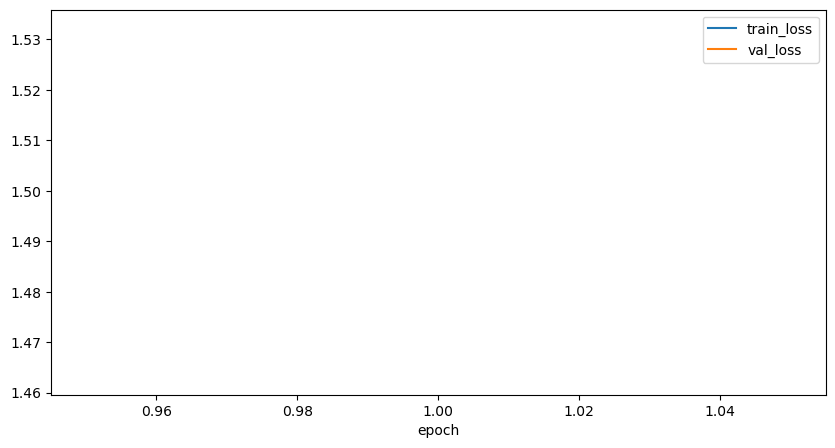

In [ ]:
results = pd.read_csv('matgl_training/training_log.csv')
results.plot(x='epoch', y=['train_loss', 'val_loss'], figsize=(10, 5))

c:\Users\efons\anaconda3\envs\meg\Lib\site-packages\dgl\readout.py:443: DGLWarning: For a single graph, use a tensor of shape (1, *) for graph_feat. The support of shape (*) will be deprecated.
  dgl_warning(


-0.3207198088786112


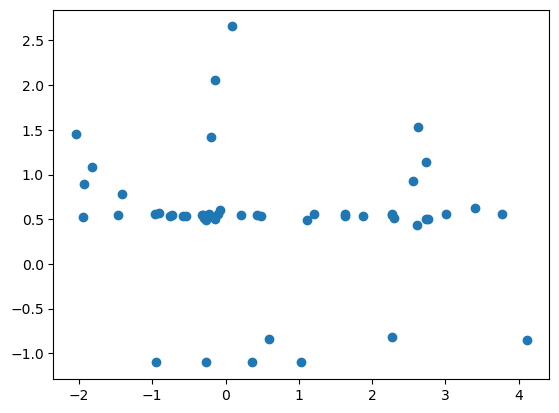

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
model.predict_structure(test_strucs[10], graph_converter=cry_graph)
# predict all the test structures
pred = torch.tensor([])
plot_x = torch.tensor([])
for i in range(len(test_strucs)):
    pred = torch.cat((pred, model.predict_structure(test_strucs[i], graph_converter=cry_graph)))
    plot_x = torch.cat((plot_x, torch.from_numpy(np.array(test_targets[i])).reshape(1, -1)))
plt.scatter(plot_x, pred.detach().numpy())
print(r2_score(plot_x, pred.detach().numpy()))
# # plot the train predictions
# pred = torch.tensor([])
# plot_x = torch.tensor([])
# for i in range(len(train_strucs)):
#     pred = torch.cat((pred, model.predict_structure(train_strucs[i], graph_converter=cry_graph)))
#     plot_x = torch.cat((plot_x, torch.from_numpy(np.array(train_targets[i])).reshape(1, -1)))
# plt.scatter(plot_x, pred.detach().numpy())

In [ ]:
def get_inputs(data):
    g = data[0]
    node_feat = g.ndata['node_type']
    edge_feat = g.edata['edge_attr']
    attrs = data[2]
    return g, node_feat, edge_feat, attrs
test_input = get_inputs(test_set[0])
print(test_input)
pred = model(test_input[0], test_input[0]['node_type'], test_input[0]['edge_attr'], test_input[3])
pred

(Graph(num_nodes=81, num_edges=4764,
      ndata_schemes={'attr': Scheme(shape=(27,), dtype=torch.float64), 'node_type': Scheme(shape=(), dtype=torch.int32), 'pos': Scheme(shape=(3,), dtype=torch.float64), 'volume': Scheme(shape=(), dtype=torch.float32)}
      edata_schemes={'pbc_offset': Scheme(shape=(3,), dtype=torch.float64), 'lattice': Scheme(shape=(1, 3, 3), dtype=torch.float64), 'pbc_offshift': Scheme(shape=(3,), dtype=torch.float64), 'edge_attr': Scheme(shape=(100,), dtype=torch.float32)}), tensor([14,  3,  3,  3,  3,  2,  2,  0,  0,  0,  0,  0,  0,  2,  2,  2,  2,  0,
         0,  2,  2,  2,  2,  0,  0,  0,  0,  0,  0,  2,  2,  0,  0,  0,  0,  2,
         2,  0,  0,  2,  2,  0,  0,  0,  0,  0,  0,  2,  2,  0,  0,  0,  0,  0,
         0,  2,  2,  0,  0,  0,  0,  2,  2,  0,  0,  2,  2,  0,  0,  0,  0,  0,
         0,  2,  2,  0,  0,  0,  0,  0,  0], dtype=torch.int32), tensor([[3.5330e-04, 4.4904e-04, 5.6864e-04,  ..., 1.6706e-01, 1.4869e-01,
         1.3186e-01],
        [5.1222

DGLError: Invalid key "node_type". Must be one of the edge types.

In [ ]:
model.forward??

Signature:
model.forward(
    graph: 'dgl.DGLGraph',
    edge_feat: 'torch.Tensor',
    node_feat: 'torch.Tensor',
    state_feat: 'torch.Tensor',
)
Source:   
    def forward(
        self,
        graph: dgl.DGLGraph,
        edge_feat: torch.Tensor,
        node_feat: torch.Tensor,
        state_feat: torch.Tensor,
    ):
        """
        Forward pass of MEGnet. Executes all blocks.

        :param graph: Input graph
        :param edge_feat: Edge features
        :param node_feat: Node features
        :param state_feat: State features.
        :return: Prediction
        """
        graph_transformations = self.graph_transformations
        edge_feat = self.edge_encoder(self.layer_edge_embedding(edge_feat))
        node_feat = self.node_encoder(self.layer_node_embedding(node_feat))
        if self.include_state_embedding:
            state_feat = self.state_encoder(self.layer_state_embedding(state_feat))
        else:
            state_feat = self.state_encoder(state_feat)

   

In [ ]:
gtest = torch.tensor([0])
bandgap = model.predict_structure(strucs[10], gtest)

IndexError: index out of range in self

In [ ]:
pred = torch.tensor([])
plot_y = torch.tensor([])
for i in range(len(test_strucs)):
    try:
        pred = torch.cat((pred,model.predict_structure(strucs[i]).unsqueeze(0)))
        plot_y = torch.cat((plot_y,torch.tensor([test_targets[i]])))
    except:
        print(i)
        continue
pred, plot_y

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


(tensor([]), tensor([]))

(0.0, 1.0)

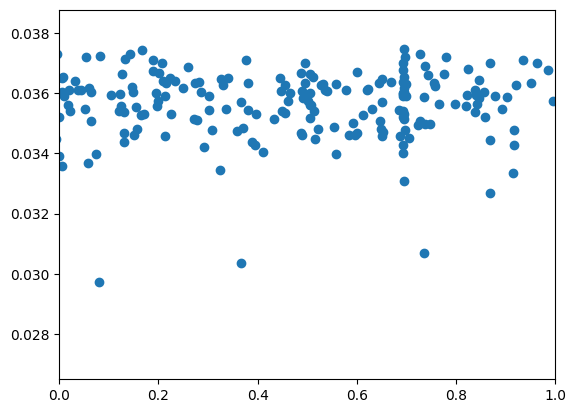

In [ ]:
plt.scatter(plot_y, pred)
plt.xlim([0, 1])